# Preâmbulo

In [ ]:
# !pip install torchtext==0.8.1

import math, time
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchtext import data, datasets

args = {
    'batch_size': 32,
    'bptt_len': 35,
    'epoch_num': 100,
    'lr': 5.0,
    'step_size': 1.0,
    'gamma': 0.95 
}

args['device'] = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Modelo de Linguagem com WikiText2

Vamos preparar um conjunto de treinamento de modelo de linguagem, cujo objetivo é sempre prever a palavra imediatamente seguinte. Para tal, dado uma sequência `frase` de `n` tokens, vamos estruturar os dados da seguinte forma:

* `entrada = frase[:-1]`
* `saida = frase[1:]`

Em outras palavras, cada par ($e_i$, $s_i$) de entrada e saída são os tokens consecutivos  $k$ e $k+1$ da nossa `frase` original. Por exemplo:

* `frase = ['qual', 'e', 'a', 'musica', '?']`
* `entrada = ['qual', 'e', 'a',      'musica']`
* `saida   = ['e',    'a', 'musica', '?']`

No pacote `torchtext` existe um iterator específico para esse tipo de carregamento, o [BPTTIterator](https://pytorch.org/text/0.8.1/data.html#bpttiterator). Dada uma entrada única contendo todo o texto de seus dados, basta informar ao iterator o `bptt_len` (aqui representando o tamanho da sequência desejada) e ele dividirá o seu texto em partes iguais de tamanho `bptt_len`.

In [ ]:
TEXT = data.Field(tokenize='basic_english')
train, val, test = datasets.WikiText2.splits(text_field=TEXT)
TEXT.build_vocab( train, max_size=25_000 )

train_loader = data.BPTTIterator(train, args['batch_size'], args['bptt_len'])
val_loader   = data.BPTTIterator(val,   args['batch_size'], args['bptt_len'])
test_loader  = data.BPTTIterator(test,  args['batch_size'], args['bptt_len']) 

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 76.2MB/s]


downloading wikitext-2-v1.zip
extracting


/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BPTTIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
print('Validation Data [0:100]:', val.examples[0].text[0:100])

for sample in test_loader:
  print('\nBatch text shape:', sample.text.shape)
  print('Batch target shape:', sample.target.shape)
  
  print('\n', sample.text)
  print('\n', sample.target)

  break

Validation Data [0:100]: ['<eos>', '=', 'homarus', 'gammarus', '=', '<eos>', '<eos>', 'homarus', 'gammarus', ',', 'known', 'as', 'the', 'european', 'lobster', 'or', 'common', 'lobster', ',', 'is', 'a', 'species', 'of', '<unk>', 'lobster', 'from', 'the', 'eastern', 'atlantic', 'ocean', ',', 'mediterranean', 'sea', 'and', 'parts', 'of', 'the', 'black', 'sea', '.', 'it', 'is', 'closely', 'related', 'to', 'the', 'american', 'lobster', ',', 'h', '.', 'americanus', '.', 'it', 'may', 'grow', 'to', 'a', 'length', 'of', '60', 'cm', '(', '24', 'in', ')', 'and', 'a', 'mass', 'of', '6', 'kilograms', '(', '13', 'lb', ')', ',', 'and', 'bears', 'a', 'conspicuous', 'pair', 'of', 'claws', '.', 'in', 'life', ',', 'the', 'lobsters', 'are', 'blue', ',', 'only', 'becoming', 'lobster', 'red', 'on', 'cooking', '.']

Batch text shape: torch.Size([35, 32])
Batch target shape: torch.Size([35, 32])

 tensor([[    9,     4,   782,  ...,   606,   431,    24],
        [   11,    24,   730,  ...,     8,    65,     3

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Transformer Model

Proposto no paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf), o trabalho foi uma sacada incrível de explorar uma arquitetura totalmente composta de blocos de **Self Attention** para realizar tarefas que até então exigiam uma arquitetura recorrente, de forma muito melhor paralelizável. 

<img width=800 src="https://lilianweng.github.io/lil-log/assets/images/transformer.png">

O PyTorch já implementa tanto o encoder quando o decoder da arquitetura do transformer, nos permitindo implementar facilmente essas camadas. Veja a documentação: https://pytorch.org/docs/master/nn.html#transformer-layers


Ambos o encoder e o decoder exigem um par de definições de camada. Precisamos definir a característica de uma única camada através do objeto ```nn.TransformerEncoderLayer```, para então replicá-los com o objeto ```nn.TransformerEncoder```, como apresentado a seguir. O mesmo vale para o decoder, com os objetos correspondentes ```nn.TransformerDecoderLayer``` e ```nn.TransformerDecoder```.

```python
encoder_layers = nn.TransformerEncoderLayer(embed_size, num_heads, hidden_size, dropout)
transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
```

Adicionalmente, precisamos implementar outros dois recursos da arquitetura:

* `PositionalEncoding`: aqui definido como um `nn.Module`, é a codificação que marca a posição de cada elemento na sequência. Por se tratar de uma arquitetura feed-forward, os transformers não implementam temporalidade nativamente. Os positional encodings vão injetar essa informação na rede.   
* `generate_square_subsequent_mask`: Essa máscara permite que o módulo de self attention relacione cada elemento da sequência apenas com si mesmo e seus antecessores (veja daqui a duas células ;) 

A implementação a seguir foi adaptada deste tutorial: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, vocab_size, embed_size, num_heads, hidden_size, num_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout)
        
        encoder_layers = nn.TransformerEncoderLayer(embed_size, num_heads, hidden_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
      
        self.embed_size = embed_size
        self.decoder = nn.Linear(embed_size, vocab_size)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.embedding(src) * math.sqrt(self.embed_size)
        src = self.pos_encoder(src)
        
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


class PositionalEncoding(nn.Module):

    def __init__(self, embed_size, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
vocab_size = len(TEXT.vocab) # the size of vocabulary
embed_size = 200 # embedding dimension
hidden_size = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
num_layers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
num_heads = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(vocab_size, embed_size, num_heads, hidden_size, num_layers, dropout).to(args['device'])
print(model)

TransformerModel(
  (embedding): Embedding(25002, 200)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
   

#### Positional Encodings

* Codificação única que marque a posição de cada palavra. 
* Deve ter a mesma dimensionalidade de `embed_size` para poder ser somada às palavras.

No paper original do transformer foi definida como:

$PE_{(pos,2i)} = sin(pos/10000^{2i/embed\_size})$<br>
$PE_{(pos,2i+1)} = cos(pos/10000^{2i/embed\_size})$

Explicação bacana: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


torch.Size([5000, 200])


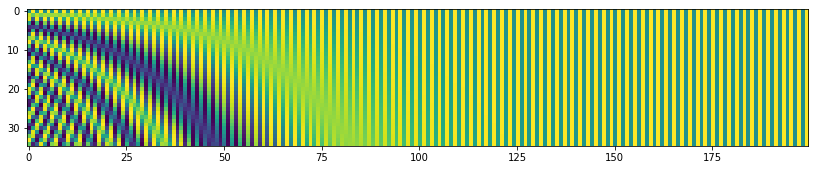

In [ ]:
plt.figure(figsize=(14, 14))
print(model.pos_encoder.pe.squeeze(1).shape)
plt.imshow(model.pos_encoder.pe.squeeze(1).cpu()[:args['bptt_len']])

#### Attention Mask

Na self attention, ambas a query e as chaves são providas pela mesma saída, já que busca-se encontrar pesos de importância para "si mesmo".

A máscara aqui é definida como uma matriz quadrada $n \times n$, onde $n$ é a quantidade de elementos da sequência (o nosso `seq_len`). Atribuindo uma máscara que forma um triângulo inferior permite-se que cada elemento $e_i$ do timestep $i$ "dê atenção" somente a si mesmo e seus antecessores.

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])


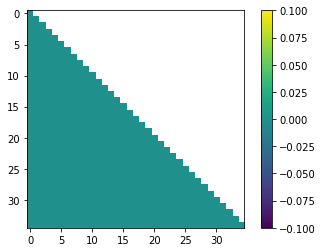

In [ ]:
src_mask = model.generate_square_subsequent_mask(args['bptt_len'])

print(src_mask)
plt.imshow(src_mask)
plt.colorbar()

## Treinando nosso Transformer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args['step_size'], args['gamma'])

In [ ]:
def train():
    
    model.train() # Turn on the train mode
    total_loss = 0.
    log_interval = len(train_loader)
    start_time = time.time()
    
    src_mask = model.generate_square_subsequent_mask(args['bptt_len']).to(args['device'])
    
    for i, batch in enumerate(train_loader):

        data = batch.text.to(args['device'])
        targets = batch.target.to(args['device'])

        # last batch
        if data.size(0) != args['bptt_len']:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(args['device'])

        optimizer.zero_grad()
        output = model(data, src_mask)

        loss = criterion(output.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        optimizer.step()

        total_loss += loss.item()
        if (i+1) % log_interval == 0:
          
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('-'*50)
            print(f'epoch {epoch} | {i+1}/{len(train_loader)} batches | '
                  f'lr {scheduler.get_lr()[0]:02.2f} | ms/batch {(elapsed * 1000 / log_interval):5.2f} | '
                  f'loss {cur_loss:5.2f}')
            print('-'*50)
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(args['bptt_len']).to(args['device'])
    
    with torch.no_grad():
        
        for i, batch in enumerate(train_loader):

            data = batch.text.to(args['device'])
            targets = batch.target.to(args['device'])

            # last batch
            if data.size(0) != args['bptt_len']:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(args['device'])

            output = eval_model(data, src_mask)
            output_flat = output.view(-1, vocab_size)
            total_loss += criterion(output_flat, targets.view(-1)).item()

    return total_loss / len(train_loader) 

In [ ]:
for epoch in range(args['epoch_num']):
    epoch_start_time = time.time()
    
    train()
    val_loss = evaluate(model, val_loader)
    
    print('*' * 50)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '.format(epoch, 
                                                                                (time.time() - epoch_start_time),
                                                                                 val_loss))
    print('*' * 50)

    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


--------------------------------------------------
epoch 0 | 1864/1864 batches | lr 5.00 | ms/batch 21.54 | loss  5.24
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


**************************************************
| end of epoch   0 | time: 54.31s | valid loss  5.16 | 
**************************************************
--------------------------------------------------
epoch 1 | 1864/1864 batches | lr 4.51 | ms/batch 21.43 | loss  5.12
--------------------------------------------------
**************************************************
| end of epoch   1 | time: 53.95s | valid loss  5.04 | 
**************************************************
--------------------------------------------------
epoch 2 | 1864/1864 batches | lr 4.29 | ms/batch 21.55 | loss  5.02
--------------------------------------------------
**************************************************
| end of epoch   2 | time: 54.26s | valid loss  4.98 | 
**************************************************
--------------------------------------------------
epoch 3 | 1864/1864 batches | lr 4.07 | ms/batch 21.54 | loss  4.93
--------------------------------------------------
****************